In [313]:
import pandas as pd
import numpy as np
import pickle
import shap

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import mean_squared_error

pd.set_option("display.max_columns", 0)

In [314]:
def get_best_parameters(X_train, y_train, max_evals=230):                                                                                                   

    kf = KFold(n_splits=5, shuffle=True, random_state=17)
    
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 300, 5),
        'max_depth': hp.quniform('max_depth', 1, 20, 1),
        'learning_rate': hp.uniform('learning_rate', 0, 1),
        'booster': hp.choice('booster', ['gbtree']),
        'gamma': hp.uniform('gamma', 0, 0.50),
        'min_child_weight': hp.uniform('min_child_weight', 0, 10),
        'subsample': hp.uniform('subsample', 0, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
        'reg_alpha': hp.uniform('reg_alpha', 0, 5),
        'reg_lambda': hp.uniform('reg_lambda', 0, 5),
    }

    def train_XGBoost(space):
    
        model = XGBRegressor(
            n_estimators      = int(space['n_estimators']),
            max_depth         = int(space['max_depth']),
            learning_rate     = space['learning_rate'],
            booster           = space['booster'],
            gamma             = space['gamma'],
            min_child_weight  = space['min_child_weight'],
            subsample         = space['subsample'],
            colsample_bytree  = space['colsample_bytree'],
            reg_alpha         = space['reg_alpha'],
            reg_lambda        = space['reg_lambda'],
            eval_metric       = 'rmse',
            random_state      = 17)

        scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')

        return{
            'loss': -np.mean(scores), 
            'loss_variance': np.var(scores, ddof=1),
            'status': STATUS_OK}

    best_hyperparameters = fmin(
        fn=train_XGBoost,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        early_stop_fn=no_progress_loss(20)
        )

    return space_eval(space, best_hyperparameters)

In [315]:
df = pd.read_csv('resources/dataset.csv', index_col=0)
df.head()

,season,matchId,team,homeTeam,awayTeam,goalsScored,goalsConceded,xGScored,xGConceded,time,date,teamOpponent,goalsScoredOpponent,goalsConcededOpponent,xGScoredOpponent,xGConcededOpponent,timeOpponent,playerId,player,homeOrAway,position,timePlayer,goals,assists,shots,yellowCard,redCard,xG,xA,bonus,xB,lastBonus,target
0,2014,5149,Chievo,Chievo,Juventus,0,0,0.0,0.0,0,2014-08-30 17:00:00,Juventus,0,0,0.0,0.0,0,1344,Nicolas Frey,h,DR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014,5149,Chievo,Chievo,Juventus,0,0,0.0,0.0,0,2014-08-30 17:00:00,Juventus,0,0,0.0,0.0,0,1331,Dario Dainelli,h,DC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014,5149,Chievo,Chievo,Juventus,0,0,0.0,0.0,0,2014-08-30 17:00:00,Juventus,0,0,0.0,0.0,0,1572,Bostjan Cesar,h,DC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014,5149,Chievo,Chievo,Juventus,0,0,0.0,0.0,0,2014-08-30 17:00:00,Juventus,0,0,0.0,0.0,0,1164,Cristiano Biraghi,h,DL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014,5149,Chievo,Chievo,Juventus,0,0,0.0,0.0,0,2014-08-30 17:00:00,Juventus,0,0,0.0,0.0,0,1339,Mariano Izco,h,MC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [317]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekDay'] = df['date'].dt.weekday

In [318]:
df['G90P'] = df['goals'] / df['timePlayer'] * 90
df['A90P'] =  df['assists'] / df['timePlayer'] * 90
df['s90P'] =  df['shots'] / df['timePlayer'] * 90
df['yC90P'] = df['yellowCard'] / df['timePlayer'] * 90
df['rC90P'] = df['redCard'] / df['timePlayer'] * 90
df['B90P'] = df['bonus'] / df['timePlayer'] * 90
df['xG90P'] = df['xG'] / df['timePlayer'] * 90
df['xA90P'] = df['xA'] / df['timePlayer'] * 90
df['xB90P'] = df['xB'] / df['timePlayer'] * 90

In [319]:
df['G90T'] = df['goalsScored'] / df['time'] * 90
df['GC90T'] = df['goalsConceded'] / df['time'] * 90
df['xG90T'] = df['xGScored'] / df['time'] * 90
df['xGC90T'] = df['xGConceded'] / df['time'] * 90

In [320]:
df['G90OT'] = df['goalsScoredOpponent'] / df['timeOpponent'] * 90
df['GC90OT'] = df['goalsConcededOpponent'] / df['timeOpponent'] * 90
df['xG90OT'] = df['xGScoredOpponent'] / df['timeOpponent'] * 90
df['xGC90OT'] = df['xGConcededOpponent'] / df['timeOpponent'] * 90

In [321]:
'''df['homeWinOdds'] = 1/df['homeWinOdds']
df['drawOdds'] = 1/df['drawOdds']
df['awayWinOdds'] = 1/df['awayWinOdds']
df['>2.5Odds'] = 1/df['>2.5Odds']
df['<2.5Odds'] = 1/df['<2.5Odds']

df['homeWinOdds'] = df['homeWinOdds']/(df['homeWinOdds'] + df['drawOdds'] + df['awayWinOdds'])
df['drawOdds'] = df['drawOdds']/(df['homeWinOdds'] + df['drawOdds'] + df['awayWinOdds'])
df['awayWinOdds'] = df['awayWinOdds']/(df['homeWinOdds'] + df['drawOdds'] + df['awayWinOdds'])
df['+2.5Odds'] = df['>2.5Odds']/(df['>2.5Odds'] + df['<2.5Odds'])
df['-2.5Odds'] = df['<2.5Odds']/(df['>2.5Odds'] + df['<2.5Odds'])'''

"df['homeWinOdds'] = 1/df['homeWinOdds']\ndf['drawOdds'] = 1/df['drawOdds']\ndf['awayWinOdds'] = 1/df['awayWinOdds']\ndf['>2.5Odds'] = 1/df['>2.5Odds']\ndf['<2.5Odds'] = 1/df['<2.5Odds']\n\ndf['homeWinOdds'] = df['homeWinOdds']/(df['homeWinOdds'] + df['drawOdds'] + df['awayWinOdds'])\ndf['drawOdds'] = df['drawOdds']/(df['homeWinOdds'] + df['drawOdds'] + df['awayWinOdds'])\ndf['awayWinOdds'] = df['awayWinOdds']/(df['homeWinOdds'] + df['drawOdds'] + df['awayWinOdds'])\ndf['+2.5Odds'] = df['>2.5Odds']/(df['>2.5Odds'] + df['<2.5Odds'])\ndf['-2.5Odds'] = df['<2.5Odds']/(df['>2.5Odds'] + df['<2.5Odds'])"

In [322]:
df = df[[
    'matchId',
    'player',
    'team',
    
    'homeTeam',
    'awayTeam',
    'homeOrAway',
    
    'season',
    'month',
    'day',
    'weekDay',
    
    'position',
    'G90P',
    'A90P',
    's90P',
    #'yC90P',
    #'rC90P',
    #'B90P',
    'xG90P',
    'xA90P',
    #'xB90P',
    'timePlayer',
    #'lastBonus',
    
    'G90T',
    'GC90T',
    'xG90T',
    'xGC90T',
    
    'G90OT',
    'GC90OT',
    'xG90OT',
    'xGC90OT',
    
    #'homeWinOdds',
    #'drawOdds',
    #'awayWinOdds',
    #'+2.5Odds',
    #'-2.5Odds',
    
    'target'
]]

In [323]:
df = df[df.position != 'GK']
df = df.fillna(0)
df.head()

,matchId,player,team,homeTeam,awayTeam,homeOrAway,season,month,day,weekDay,position,G90P,A90P,s90P,xG90P,xA90P,timePlayer,G90T,GC90T,xG90T,xGC90T,G90OT,GC90OT,xG90OT,xGC90OT,target
0,5149,Nicolas Frey,Chievo,Chievo,Juventus,h,2014,8,30,5,DR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5149,Dario Dainelli,Chievo,Chievo,Juventus,h,2014,8,30,5,DC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5149,Bostjan Cesar,Chievo,Chievo,Juventus,h,2014,8,30,5,DC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5149,Cristiano Biraghi,Chievo,Chievo,Juventus,h,2014,8,30,5,DL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5149,Mariano Izco,Chievo,Chievo,Juventus,h,2014,8,30,5,MC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [324]:
metadata = df[['matchId', 'player', 'team']]
X = df.drop(columns=['matchId', 'player', 'team', 'target'])
y = df.target

X_train_raw, X_test_raw, y_train, y_test, metadata_train, metadata_test = train_test_split(X, y, metadata, test_size=0.33, random_state=17)

In [325]:
categorical_columns = ['homeTeam', 'awayTeam', 'homeOrAway', 'position']
numerical_columns = [column for column in list(X.columns) if column not in categorical_columns]

In [326]:
ct = ColumnTransformer([
    ("scaler", StandardScaler(), numerical_columns),
    ("encoder", OneHotEncoder(drop='if_binary', sparse=False), categorical_columns)    
])

In [327]:
X_train_values = ct.fit_transform(X_train_raw)
X_test_values = ct.transform(X_test_raw)

In [328]:
with open('model/transformer.pkl', 'wb') as f:
    pickle.dump(ct, f)

In [329]:
feature_names = ct.transformers_[0][2]
encoded_features = ct.transformers_[1][1].get_feature_names()

temp = []
for index, feature in enumerate(ct.transformers_[1][2]):
    for column in encoded_features:
        if 'x'+str(index)+'_' in column:
            temp.append(column.replace('x'+str(index)+'_', feature+'_'))
            
feature_names.extend(temp)

In [330]:
X_train = pd.DataFrame(data=X_train_values, columns=feature_names)
X_test = pd.DataFrame(data=X_test_values, columns=feature_names)

X_train.head()

,season,month,day,weekDay,G90P,A90P,s90P,xG90P,xA90P,timePlayer,G90T,GC90T,xG90T,xGC90T,G90OT,GC90OT,xG90OT,xGC90OT,homeTeam_AC Milan,homeTeam_Atalanta,homeTeam_Benevento,homeTeam_Bologna,homeTeam_Brescia,homeTeam_Cagliari,homeTeam_Carpi,homeTeam_Cesena,homeTeam_Chievo,homeTeam_Crotone,homeTeam_Empoli,homeTeam_Fiorentina,homeTeam_Frosinone,homeTeam_Genoa,homeTeam_Inter,homeTeam_Juventus,homeTeam_Lazio,homeTeam_Lecce,homeTeam_Napoli,homeTeam_Palermo,homeTeam_Parma,homeTeam_Parma Calcio 1913,homeTeam_Pescara,homeTeam_Roma,homeTeam_SPAL 2013,homeTeam_Salernitana,homeTeam_Sampdoria,homeTeam_Sassuolo,homeTeam_Spezia,homeTeam_Torino,homeTeam_Udinese,homeTeam_Venezia,homeTeam_Verona,awayTeam_AC Milan,awayTeam_Atalanta,awayTeam_Benevento,awayTeam_Bologna,awayTeam_Brescia,awayTeam_Cagliari,awayTeam_Carpi,awayTeam_Cesena,awayTeam_Chievo,awayTeam_Crotone,awayTeam_Empoli,awayTeam_Fiorentina,awayTeam_Frosinone,awayTeam_Genoa,awayTeam_Inter,awayTeam_Juventus,awayTeam_Lazio,awayTeam_Lecce,awayTeam_Napoli,awayTeam_Palermo,awayTeam_Parma,awayTeam_Parma Calcio 1913,awayTeam_Pescara,awayTeam_Roma,awayTeam_SPAL 2013,awayTeam_Salernitana,awayTeam_Sampdoria,awayTeam_Sassuolo,awayTeam_Spezia,awayTeam_Torino,awayTeam_Udinese,awayTeam_Venezia,awayTeam_Verona,homeOrAway_h,position_AMC,position_AML,position_AMR,position_DC,position_DL,position_DMC,position_DML,position_DMR,position_DR,position_FW,position_FWL,position_FWR,position_MC,position_ML,position_MR,position_Sub
0,0.750175,-1.210616,-0.049583,0.665700,0.279267,0.640349,1.886940,1.309554,0.876979,1.085553,0.319496,0.202871,0.864386,-0.093527,0.457049,0.285553,-0.187785,0.847803,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.156436,-0.689060,-1.063009,0.111395,-0.531355,0.539846,0.184488,-0.376604,1.096909,-0.596776,0.053507,-0.479609,0.314715,-0.620170,0.480376,-1.019784,1.129648,-0.529699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.516353,1.397164,0.513432,0.665700,2.039345,1.307646,1.171907,2.045711,1.647492,-0.135958,-0.053822,-0.900602,-0.359232,0.722582,-1.129193,-0.416918,-0.522529,-0.469450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.296870,1.397164,1.414255,0.111395,0.005555,0.255608,-0.037924,0.534675,0.079791,-0.357426,0.751146,0.041621,1.136326,-0.186506,0.301535,0.145757,0.109134,0.368280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.516353,-0.689060,-0.499994,0.665700,1.051378,0.057094,0.718341,0.975187,0.527137,1.141951,0.020198,-1.157761,0.075835,-1.041691,-0.315158,-0.533334,-0.140845,-0.608105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [331]:
best_params = get_best_parameters(X_train, y_train, max_evals=128)

 33%|████████████████████████████████████████████████████▌                                                                                                           | 42/128 [35:53<1:13:29, 51.27s/trial, best loss: 1.0534510047956904]


In [332]:
best_params

{'booster': 'gbtree',
 'colsample_bytree': 0.8510064066956867,
 'gamma': 0.3791521071347438,
 'learning_rate': 0.18288312635236542,
 'max_depth': 2.0,
 'min_child_weight': 5.793334063625282,
 'n_estimators': 110.0,
 'reg_alpha': 3.155036397179337,
 'reg_lambda': 4.424234799881388,
 'subsample': 0.7291964091503814}

In [333]:
with open('model/best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)

In [334]:
model = XGBRegressor(
    n_estimators      = int(best_params['n_estimators']),
    max_depth         = int(best_params['max_depth']),
    learning_rate     = best_params['learning_rate'],
    booster           = best_params['booster'],
    gamma             = best_params['gamma'],
    min_child_weight  = best_params['min_child_weight'],
    subsample         = best_params['subsample'],
    colsample_bytree  = best_params['colsample_bytree'],
    reg_alpha         = best_params['reg_alpha'],
    reg_lambda        = best_params['reg_lambda'],
    objective         = 'reg:squarederror',
    eval_metric       = 'rmse',
    random_state      = 17)

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8510064066956867,
             enable_categorical=False, eval_metric='rmse',
             gamma=0.3791521071347438, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.18288312635236542,
             max_delta_step=0, max_depth=2, min_child_weight=5.793334063625282,
             missing=nan, monotone_constraints='()', n_estimators=110, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=17,
             reg_alpha=3.155036397179337, reg_lambda=4.424234799881388,
             scale_pos_weight=1, subsample=0.7291964091503814,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [335]:
with open('model/model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [336]:
y_pred = model.predict(X_test)

In [337]:
mean_squared_error(y_test, y_pred, squared=False)

1.0342811974779182

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


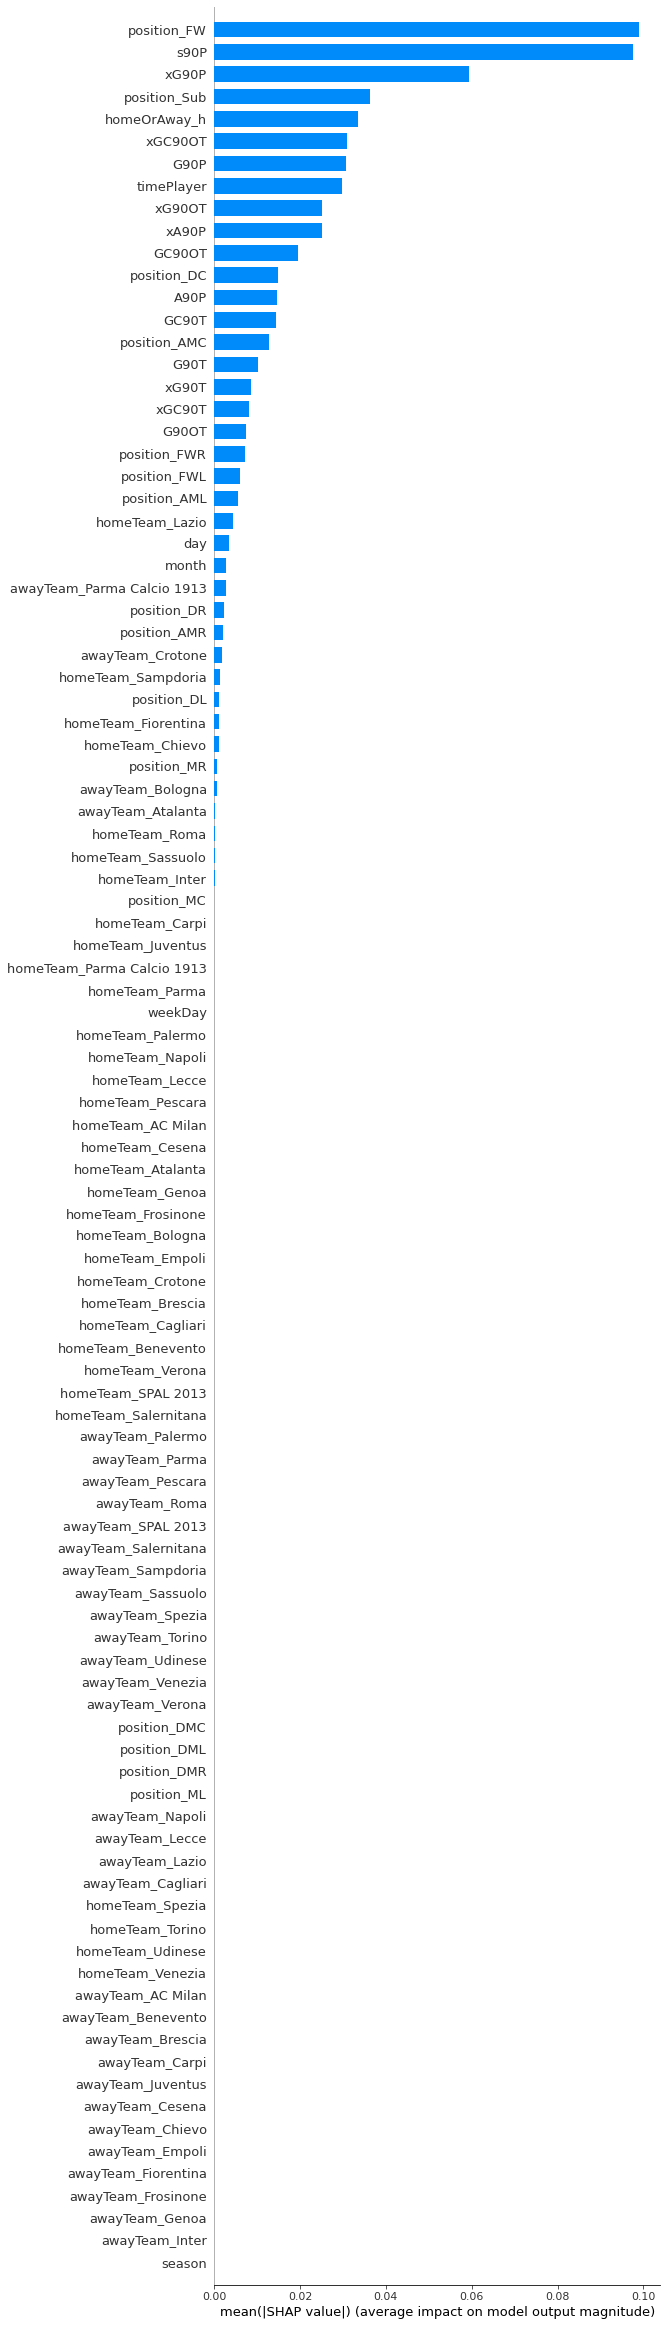

In [338]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, max_display=200, plot_type='bar', show=False, sort=True)